## Joint prior model

### Steps to follow
1. get the data  
2. initial the free parameter  
3. comvert the parameter to probability  
 (a) compute the $\mu$, $\sigma$, $w$ for AV according to eq 1-3  
 (b) function that convert to prob
4. negative log likelihood - multinominal   
  use <i>minimize</i> function   
  error computation per each stimulus, summed

<img src="./img/steps.png" width = "800"  alt="steps" align=center />

#### import library

In [1]:
import pickle
from scipy.optimize import minimize
import numpy as np
import scipy.stats
from scipy.special import factorial

#### Step1: read in data

In [2]:
pkl_path = '../S2_data/data.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

In [3]:
print('data keys:'+str(data.keys()))
print('shape of data[\'AG\'][\'props\']:\t'+str(data['AG']['props'].shape))

data keys:dict_keys(['AB', 'AG', 'VB', 'VG', 'AVB', 'AVG', 'AVFus', 'dim_order', 'response_order', 'nsubjects'])
shape of data['AG']['props']:	(16, 3, 3)


#### step2: initial the free parameters

We have the following free parameters:  
1. $\sigma_0$, which indicates the variance of the prior, representing the strength of the audio-visual intergration.  
2. 4 mean value for all combinations of audio-visual/GA-BA, $\mu_{vg},\mu_{vb},\mu_{ag},\mu_{ab}$
3. 6 kinds of variance for all combinations of audio-visual/high-mid-low, $\sigma_{vh}$,$\sigma_{vm}$,$\sigma_{vl}$,$\sigma_{ah}$,$\sigma_{am}$,$\sigma_{al}$
4. the 2 decision boundaries for seprerate BA,DA,GA , $interval_{bd}$ , $interval_{dg}$ 

In [203]:
# define the free parameters
sigma_0 = 0
mu_vg, mu_vb, mu_ag, mu_ab = 0,0,0,0
sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al = 1,1,1,1,1,1
interval_bd,interval_dg = -0.2,0.2

init_para = [sigma_0,mu_vg, mu_vb, mu_ag, mu_ab,sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al,interval_bd,interval_dg]

#### step3: convert the parameter to probability

(a) compute the  𝜇 ,  𝜎 ,  𝑤  for AV according to eq 1-3  
(b) function that convert to prob


$$\mu_{AV} = w_A \mu_A + (1-w_A)\mu_V \tag{1}$$
$$\sigma_{AV}^2 = w_A \sigma_A^2 \tag{2}$$
$$w_A = \frac{2\sigma_0^2 + \sigma_V^2}{2\sigma_0^2 + \sigma_V^2+\sigma_A^2} \tag{3}$$


In [204]:
def get_av(mu_a,mu_v,sigma_a,sigma_v,sigma_0 = 0):
    '''
    compute the mu and sigma for audiovisual perception
    '''
    w = (2*sigma_0**2+sigma_v**2)/(2*sigma_0**2+sigma_v**2 + sigma_a**2)
    mu_av = w*mu_a + (1-w)*mu_v
    sigma_av = np.sqrt((sigma_a**2)*w)
    return mu_av,sigma_av

In [175]:
def guassian2prob(mu,sigma,c):
    """
    input:
    - mu: mean of truncated Gaussian,shape [m * 1]
    - sigma: shape [m * 1]
    - c: the intervals [m * 2] or uniformed ([1 * 2])
    it could be same for all stimuli, or could be different for different stimuli

    output:
    - response_probs: [m * 3] responsed probabilities
    """
    m = len(mu)
    response_probs = np.zeros((m,3))
    low = -5
    high = 5
    c = c.reshape(-1,2)
#     print(c.shape)
    
    if len(c) == 1:
        c = np.tile(c,(m,1))
#     print(c.shape)
#     print(c)
#     print(c[0,:])
    
    low_boundary =  scipy.stats.norm.cdf(low,mu,sigma)
    up_boundary =  scipy.stats.norm.cdf(high,mu,sigma)
    normalization_constant = up_boundary - low_boundary
    
    resp_bound_low = scipy.stats.norm.cdf(c[:,0],mu,sigma)
    resp_bound_high = scipy.stats.norm.cdf(c[:,1],mu,sigma)
    
    response_probs[:,0] = np.exp(np.log(resp_bound_low - low_boundary)-np.log(normalization_constant))
    response_probs[:,1] = np.exp(np.log(resp_bound_high - resp_bound_low)-np.log(normalization_constant))
    response_probs[:,2] = np.exp(np.log(up_boundary - resp_bound_high)-np.log(normalization_constant))
    
    return response_probs

In [205]:
# try out
guassian2prob(np.array([0,0]),np.array([1,1]),np.array([[-0.5,0.5]]))

array([[0.30853743, 0.38292514, 0.30853743],
       [0.30853743, 0.38292514, 0.30853743]])

**Step 4: optimize the parameters via minimizing the neg-log-multinomial likelihood (maximizing likelihood)**   
negative log likelihood - multinominal   
  use <i>minimize</i> function   
  error computation per each stimulus, summed

The likelihood function for the multinomial distribution is:  


$$L(x;\theta) = \frac{N!}{\prod\limits_{i} x_i!} \prod\limits_{i} \theta_i^{x_i} \tag{4}$$

The logarithm of equation $(3)$:

$$l(x;\theta) = log(N!) - \sum\limits_{i} \log{x_i!} + \sum\limits_{i}x_i\log(\theta_i) \tag{5}$$

*Minimize* the negative-log likelihood: 

$$minimize(-l(x;\theta)) = minimize(-log(N!) +\sum\limits_{i} \log{x_i!} - \sum\limits_{i}x_i\log(\theta_i)) \tag{6}$$

ref:   
https://www.youtube.com/watch?v=rtH7ia9Y5HM  
https://cmci.colorado.edu/classes/INFO-2301/sp17/files/06.pdf


<font color=coral>
    1. $\lambda$ term?<br>     
    2. for each tester?
    </font>

<font color=red>problems encountered:  </font><br>
1. when res_prob is 0, np.log(res_prob) returns -inf, then the multiply would go wrong.
2. the result seems not match SNR

In [193]:
def log_max_likelihood_each(counts,mu,sigma,c):
    '''
    compute the maximum log likelihood
    
    input:
    - counts: shape of [m, 3] 
    - mu, sigma: corresponding mu and sigma,shape [m, 1] [m, 1]
    - c: the 2 boundaries, shape of [1,2] 
    '''
    x = np.array(counts)
#     print('x.shape:{}'.format(x.shape))
#     print(x)
    
    # get the response prob first
    res_prob = guassian2prob(mu,sigma,c)
#     print('res_prob.shape:{}'.format(res_prob.shape))
#     print(res_prob)
    
    N = np.sum(x,axis=1)
#     print('N:{}'.format(N))
    
    log_N_fact = np.log(factorial(N))
#     print('log_N_fact.shape:{}'.format(log_N_fact.shape))
#     print(log_N_fact)
    
    sum_log_fact = np.sum(np.log(factorial(x)),axis=1)
#     print('sum_log_fact.shape:{}'.format(sum_log_fact.shape))
#     print(sum_log_fact)

    # if res_prob is 0 -> replace it with penalty-constant
#     res_prob[np.argwhere(res_prob == 0)] = 1e-100
#     res_prob[np.isnan(res_prob)] = 1e-50
    log_res_prob = np.log(res_prob)
    log_res_prob[np.isinf(log_res_prob)] = -1e6
#     if len(np.argwhere(np.isnan(log_res_prob))) != 0:
#     print('log_res_prob:{}'.format(log_res_prob))
    sum_xi_log = np.sum(np.multiply(x,log_res_prob),axis=1)
#     print('sum_xi_log.shape:{}'.format(sum_xi_log.shape))
#     print(sum_xi_log)
    
    
    res = log_N_fact - sum_log_fact + sum_xi_log
    
    return np.sum(res)

In [194]:
def get_params_AV(mu_1,mu_2):
    '''
    compute the array of mu and sigma for multi-sesories
    input:
    - mu_1 : mu for audio
    - mu_2 : mu for visual
    return:
    the array of mu and sigma of the defined-combinations in experiment
    '''
    # get the mu_av, sigma_av 
    
    # Vhi_Ahi,Vmid_Ahi,Vlo_Ahi,Vhi_Amid,Vhi_Alo
    mu_Vhi_Ahi, sigma_Vhi_Ahi = get_av(mu_1, mu_2, sigma_vh,sigma_ah)
    mu_Vmid_Ahi, sigma_Vmid_Ahi = get_av(mu_1, mu_2, sigma_vm,sigma_ah)
    mu_Vlo_Ahi, sigma_Vlo_Ahi = get_av(mu_1, mu_2, sigma_vl,sigma_ah)
    mu_Vhi_Amid, sigma_Vhi_Amid = get_av(mu_1, mu_2, sigma_vh,sigma_am)
    mu_Vhi_Alo, sigma_Vhi_Alo = get_av(mu_1, mu_2, sigma_vh,sigma_al)

    mus = np.array([mu_Vhi_Ahi,mu_Vmid_Ahi,mu_Vlo_Ahi,mu_Vhi_Amid,mu_Vhi_Alo])
    sigmas = np.array([sigma_Vhi_Ahi,sigma_Vmid_Ahi,sigma_Vlo_Ahi,sigma_Vhi_Amid,sigma_Vhi_Alo])
    return mus, sigmas

In [195]:


neg_log = [] # use to record the neg-log-multi-nomial likelihood
tester_index = 10 # tester index



def neg_log_guassian(x0):
    # get the parameter out from x0
    sigma_0 = x0[0]
    [mu_vg, mu_vb, mu_ag, mu_ab] = x0[1:5]
    [sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al] = x0[5:11]
    c = x0[11:]
    
    #data['AB']
    res_ab = log_max_likelihood_each(data['AB']['counts'][tester_index,:,:],
                                np.array([mu_ab]*3),
                                np.array([sigma_ah,sigma_am,sigma_al]),c)
    
    #data['AG']
    res_ag = log_max_likelihood_each(data['AG']['counts'][tester_index,:,:],
                                np.array([mu_ag]*3),
                                np.array([sigma_ah,sigma_am,sigma_al]),c)
    
    #data['VB']
    res_vb = log_max_likelihood_each(data['VB']['counts'][tester_index,:,:],
                                np.array([mu_vb]*3),
                                np.array([sigma_vh,sigma_vm,sigma_vl]),c)
    
    #data['VG']
    res_vg = log_max_likelihood_each(data['VG']['counts'][tester_index,:,:],
                                np.array([mu_vg]*3),
                                np.array([sigma_vh,sigma_vm,sigma_vl]),c)
    
    
    
    
    #data['AVFus']['synch']
    # AVFus -> auditory B , visual G
    mus, sigmas = get_params_AV(mu_ab,mu_vg)
#     print('AVFus,mus:{}'.format(mus))
#     print('AVFus,sigmas:{}'.format(sigmas))
    res_avfus = log_max_likelihood_each(data['AVFus']['synch']['counts'][tester_index,:,:],
                                 mus,sigmas,c)
    

    #data['AVG']['synch']
    mus, sigmas = get_params_AV(mu_ag,mu_vg)
    res_avg = log_max_likelihood_each(data['AVG']['synch']['counts'][tester_index,:,:],
                                 mus,sigmas,c)
    
    #data['AVB']['synch']
    mus, sigmas = get_params_AV(mu_ab,mu_vb)
    res_avb = log_max_likelihood_each(data['AVB']['synch']['counts'][tester_index,:,:],
                                 mus,sigmas,c)
    
    
    res = res_ab + res_ag + res_vb + res_vg + res_avfus + res_avg + res_avb
    neg_log.append(-res)
    return -(res)
    

x0 = np.array(init_para)
res = minimize(neg_log_guassian, x0,method='Nelder-Mead', tol=1e-6)

# init_para = [sigma_0,mu_vg, mu_vb, mu_ag, mu_ab,sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al,interval_bd,interval_dg]


c:\users\12632\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


The optimized parameters:

In [206]:
[sigma_0,mu_vg, mu_vb, mu_ag, mu_ab,sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al,interval_bd,interval_dg] = res.x
print('sigma_0:{}'.format(sigma_0))
print('mu_vg:{},mu_vb:{},mu_ag:{}, mu_ab:{}'.format(mu_vg, mu_vb, mu_ag, mu_ab))
print('sigma_vh:{}, sigma_vm:{}, sigma_vl:{}, sigma_ah:{}, sigma_am:{}, sigma_al:{}'.format(sigma_vh, sigma_vm, sigma_vl, sigma_ah, sigma_am, sigma_al))
print('interval_bd:{},interval_dg:{}'.format(interval_bd,interval_dg))

sigma_0:0.0002557161983943036
mu_vg:0.001781536990039342,mu_vb:0.010154435483631473,mu_ag:-0.017526772276325167, mu_ab:-0.007218806815071841
sigma_vh:3.3952647840596377, sigma_vm:4.267945362455463, sigma_vl:0.41695452792626564, sigma_ah:0.23897408889115337, sigma_am:0.3721583899334301, sigma_al:0.81711802498426
interval_bd:0.0541874098965414,interval_dg:0.05437777216897064


The trend of neg-log-likelihood with iterations:

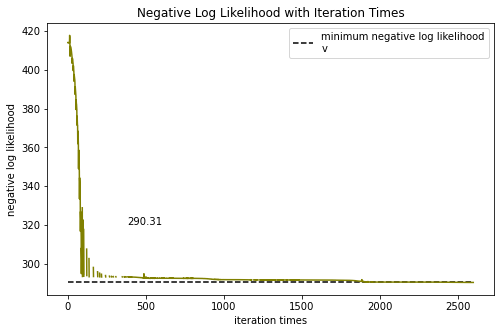

In [202]:
# plot the trend of negative log likelihood
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,len(neg_log)+1)
plt.figure(figsize=(8,5))
plt.plot(x,neg_log,color = 'olive')
plt.hlines(res.fun,xmin = 0,xmax = len(neg_log)+1,linestyles='dashed',color= 'k',linewidth=1.5,label='minimum negative log likelihood\nv')
plt.text(380, res.fun+30, '{:.2f}'.format(res.fun), fontsize=10)
plt.xlabel('iteration times')
plt.ylabel('negative log likelihood')
plt.title('Negative Log Likelihood with Iteration Times')
plt.legend()
plt.show()

In [27]:
print(data['AVFus']['synch']['snr'])


[[array(['Vhi_Ahi'], dtype='<U7') array(['Vmid_Ahi'], dtype='<U8')
  array(['Vlo_Ahi'], dtype='<U7') array(['Vhi_Amid'], dtype='<U8')
  array(['Vhi_Alo'], dtype='<U7')]]
